모듈 ∙ 라이브러리 import

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

데이터 불러오기

In [21]:
# 데이터 로드   
stock_df = pd.read_csv('/Users/moon/Desktop/Moon SeungHoo/Stock_Machine_Learning/StockData_Setting.csv',low_memory=False)
pred_df = pd.read_csv('/Users/moon/Desktop/Moon SeungHoo/Stock_Machine_Learning/StockData_Pred.csv',low_memory=False)

pred_tiker = pred_df['0']
#불필요한 데이터 삭제
stock_df = stock_df.drop({'7','0','1'},axis=1)
stock_l_df = stock_df['18'].reset_index().set_index('index')
stock_df = stock_df.drop({'18'},axis=1)

pred_df = pred_df.drop({'7','0','1'},axis=1)

데이터 전처리

In [23]:
scaler = MinMaxScaler()
stock_l_df['18'] = scaler.fit_transform(stock_l_df['18'].values.reshape(-1, 1))



데이터 분할

In [24]:
# # 데이터를 입력 및 출력으로 나누기
# sequence_length = 20
# X, y = [], []
# for i in range(len(stock_df) - sequence_length):
#     X.append(stock_df.values[i:i+sequence_length])
#     y.append(int(stock_df['18'].values[i+sequence_length] > stock_df['18'].values[i+sequence_length-1]))

# X = np.array(X)
# y = np.array(y)

# 훈련 및 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(stock_df, stock_l_df, test_size=0.2, random_state=42)

GRU 모델 정의

In [25]:
# GRU 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(50, input_shape=(X_train.shape[1], 1)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

모델 훈련

In [26]:
# 모델 훈련
model.fit(X_train, y_train, epochs=5, batch_size=32)
# 모델 저장
model.save("GRU_Model.h5")

Epoch 1/5


2023-10-20 21:46:37.376162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-20 21:46:37.622756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-20 21:46:40.053564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22324/22324 [==============================] - 237s 10ms/step - loss: 0.1203 - accuracy: 0.9628
Epoch 2/5
22324/22324 [==============================] - 241s 11ms/step - loss: 0.1037 - accuracy: 0.9652
Epoch 3/5
22324/22324 [==============================] - 245s 11ms/step - loss: 0.1017 - accuracy: 0.9658
Epoch 4/5
22324/22324 [==============================] - 258s 12ms/step - loss: 0.1003 - accuracy: 0.9660
Epoch 5/5
22324/22324 [==============================] - 259s 12ms/step - loss: 0.0998 - accuracy: 0.9660


/Users/moon/anaconda3/envs/ML/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


모델 평가

In [27]:
# 모델 로드
loaded_model = tf.keras.models.load_model("GRU_Model.h5")

# 모델 평가
loss, accuracy = loaded_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

# 모델을 사용하여 주가 상승 여부 예측
predictions = loaded_model.predict(X_test)

# 예측 결과를 이진값(0 또는 1)으로 변환
binary_predictions = (predictions > 0.5).astype(int)

# 예측 결과 출력
correct_predictions = np.equal(binary_predictions, y_test)  # 정확하게 예측한 경우 True, 그렇지 않으면 False
accuracy = np.mean(correct_predictions)  # 정확도 계산

print(f"정확도: {accuracy * 100:.2f}%")


2023-10-20 22:13:54.411600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-20 22:13:54.499151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5581/5581 [==============================] - 34s 6ms/step - loss: 0.1099 - accuracy: 0.9654
Test Loss: 0.10985979437828064, Test Accuracy: 0.9654229879379272


2023-10-20 22:14:28.253400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-20 22:14:28.290065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5581/5581 [==============================] - 20s 4ms/step
정확도: 96.54%


예측

In [31]:
def make_six_digit_list(input_list):
    six_digit_list = []

    for item in input_list:
        # 현재 항목의 길이를 확인
        item_str = str(item)
        item_len = len(item_str)

        if item_len < 6:
            # 6자리가 안되는 항목은 앞에 0을 채워서 6자리로 만듭니다.
            zero_padding = '0' * (6 - item_len)
            six_digit_item = zero_padding + item_str
            six_digit_list.append(six_digit_item)
        else:
            # 이미 6자리인 경우 그대로 유지
            six_digit_list.append(item_str)

    return six_digit_list

In [32]:
# 모델 로드
loaded_model = tf.keras.models.load_model("GRU_Model.h5")

pred = loaded_model.predict(pred_df)
# 5% 이상 오를 종목 식별
threshold = 0.5
rising_stocks = [ticker for i, ticker in enumerate(pred_tiker) if pred[i] > threshold]
rising_stocks = list(map(str, rising_stocks))
result = list(set(rising_stocks))
result = make_six_digit_list(result)
print("내일 5% 이상 상승할 종목:", result)
print(len(result))

2023-10-20 22:18:33.001810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-20 22:18:33.039833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1531/1531 [==============================] - 6s 4ms/step
내일 5% 이상 상승할 종목: ['214370', '040350', '234100', '037460', '035620', '370090', '060570', '018670', '078020', '094940', '085660', '123420', '010820', '210980', '043100', '037950', '066430', '191410', '238120', '115610', '054930', '032080', '028080', '129920', '001940', '018700', '026940', '313760', '094860', '008830', '053050', '288980', '900300', '065500', '244920', '014530', '058860', '053260', '143160', '096630', '038530', '117580', '258830', '044380', '195990', '032500', '016600', '138080', '017670', '069410', '002800', '008290', '000155', '008600', '101400', '054300', '010660', '032820', '123840', '039490', '303530', '084680', '052400', '153490', '050110', '013810', '330350', '051780', '950130', '380540', '052600', '359090', '066790', '009420', '151910', '034940', '091970', '000157', '900110', '082210', '204610', '005870', '016880', '007770', '009620', '038460', '049080', '009140', '094820', '002360', '024060', '179530', '2900

예측한 결과 검증

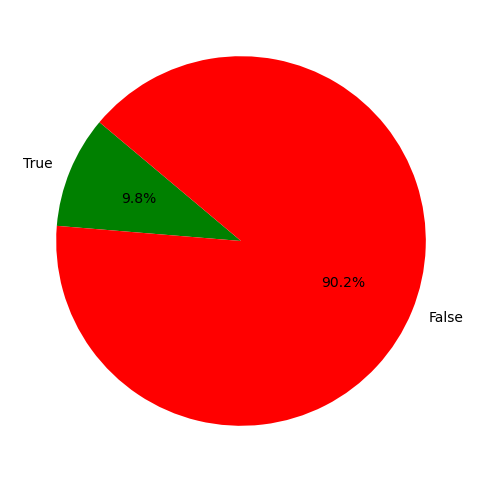

In [33]:
def check_price_increase(stock_codes):
    result = {}
    
    for code in stock_codes:
        df = fdr.DataReader(code,'2023-10-12','2023-10-13')
        
        if len(df) < 2:
            result[code] = False
        else:
            today_close = df['Close'].iloc[-1]
            yesterday_close = df['Close'].iloc[-2]
            
            if today_close >= yesterday_close * 1.05 :
                result[code] = True
            else:
                result[code] = False
    return result

result_TF = check_price_increase(result)
result_TF = list(result_TF.values())

# True와 False의 개수를 세어 비율을 계산
true_count = sum(result_TF)
false_count = len(result_TF) - true_count

# 비율을 파이그래프로 표현
labels = ['True', 'False']
sizes = [true_count, false_count]
colors = ['green', 'red']

# 파이차트 그리기
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# 그래프 표시
plt.show() 